# ex04-Deal with DEM in ASCIIGRID Format

Another means of storing raster data, often elevation data, is in ASCII Grid files, or ASCIIGRID. This grid format stores data in equal-sized square rows and columns, where each cell in a row/column stores a single numeric value as a text. Such a kind of format can represent some feature of terrain, such as elevation, slope, or flow direction. Its spatial information is contained in a simple header. The format of the file is as follows:

NCOLS xxx
    
NROWS xxx
    
XLLCENTER xxx | XLLCORNER xxx

YLLCENTER xxx | YLLCORNER xxx

CELLSIZE xxx
    
NODATA_VALUE xxx
 
The simplicity makes it an easy-to-use and platformindependent raster format. This file format was created by Esri, but has become an unofficial standard supported by most software packages.

As the data are stored as simple plain text, they could be easily loaded into ***NumPy*** arrays. However, you have to deal with its spatial information (such as coordinates) manually. Sometimes, it is a little bit annoying as coordinate along y (or latitude) must be flipped up-down. As [xarray](http://xarray.pydata.org/en/stable/) is always my favorite tool, this notebook will also apply it. However, it is worth noting that xarray uses the [rasterio](https://rasterio.readthedocs.io/en/stable/) library as the backend engine to read DEM data. :) using xarray + rasterio will save quite a few lines of source code.

In [1]:
%matplotlib inline

import numpy as np
import xarray as xr
from linecache import getline
import cmaps as nclcmaps

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## 1. Use pure python

In [2]:
infile  = "data/FloodFill/terrain.asc"

# Parse the header using a loop and the built-in linecache module
header = [getline(infile, i) for i in np.arange(1, 7)]
values = [float(h.split(" ")[-1].strip()) for h in header]
cols, rows, lx, ly, cell, nd = values
res    = cell
arr_dem = np.loadtxt(infile, skiprows=6)
arr_dem[arr_dem<=nd] = np.nan

lons   = lx + np.arange(cols)*res
lats_r = ly + np.arange(rows)*res
lats   = lats_r[::-1] # keep in mind to flip up-down latitude.

***Visualization***

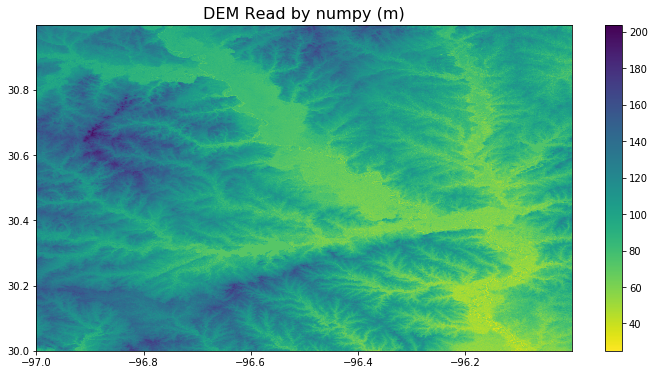

In [3]:
fig, ax = plt.subplots(figsize=(12, 6))
cs = ax.pcolormesh(lons, lats,
                   arr_dem, 
                   cmap=nclcmaps.MPL_viridis_r
                  )
fig.colorbar(cs)
#ax.axis('off')
_ = ax.set_title('DEM Read by numpy (m)', fontsize=16)

## 2. Use xarray

In [4]:
da_dem = xr.open_rasterio(infile).drop('band')[0].rename({'x':'longitude', 'y':'latitude'})
nodata = da_dem.nodatavals[0]
da_dem = da_dem.where(da_dem>nodata, np.nan)

***Visualization***

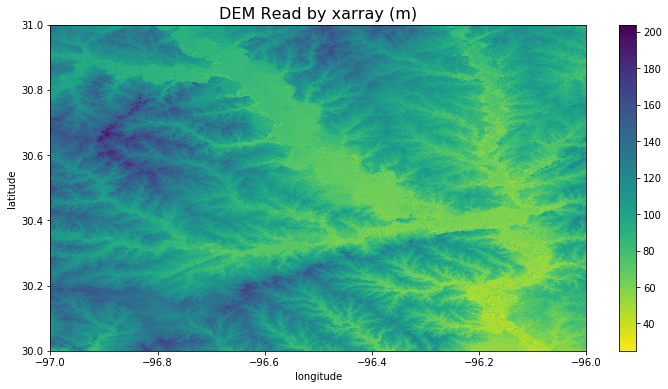

In [5]:
fig, ax = plt.subplots(figsize=(12, 6))
da_dem.plot(ax=ax,           
            cmap=nclcmaps.MPL_viridis_r,
           )
#ax.axis('off')
_ = ax.set_title('DEM Read by xarray (m)', fontsize=16)

Both methods get the same results. So why not to use the one with less lines of code?

## References

Travis E, Oliphant. A guide to NumPy, USA: Trelgol Publishing, (2006).

Stéfan van der Walt, S. Chris Colbert and Gaël Varoquaux. The NumPy Array: A Structure for Efficient Numerical Computation, Computing in Science & Engineering, 13, 22-30 (2011), DOI:10.1109/MCSE.2011.37

Fernando Pérez and Brian E. Granger. IPython: A System for Interactive Scientific Computing, Computing in Science & Engineering, 9, 21-29 (2007), DOI:10.1109/MCSE.2007.53

John D. Hunter. Matplotlib: A 2D Graphics Environment, Computing in Science & Engineering, 9, 90-95 (2007), DOI:10.1109/MCSE.2007.55

https://rasterio.readthedocs.io/en/stable/

http://xarray.pydata.org/en/stable/